In [ ]:
!pip install -q -U keras-tuner

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers
import kerastuner as kt
from keras.layers.advanced_activations import PReLU
from tensorflow.keras.layers import BatchNormalization
from keras.layers.wrappers import Bidirectional
#import tensorflow_addons as tfa

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
data = pd.read_csv('/content/gdrive/My Drive/TSLA.csv', date_parser = True)

In [ ]:
data.shape

(2711, 7)

In [ ]:
data_training = data[data['Date']<'2020-01-01'].copy()
data_test = data[data['Date']>='2020-01-01'].copy()

In [ ]:
data_training = data_training.drop(['Date', 'Adj Close'], axis = 1)
data_test = data_test.drop(['Date', 'Adj Close'], axis = 1)

In [ ]:
data_test[-1:]

,Open,High,Low,Close,Volume
2710,690.299988,696.549988,681.369995,691.619995,28234200


In [ ]:
day_interval=60

In [ ]:
past_30_days = data_training.tail(day_interval)
df = past_30_days.append(data_test)

In [ ]:
scaler = MinMaxScaler()
data_training = scaler.fit_transform(data_training)

In [ ]:
train_size = data_training.shape[0]
print(train_size)

2394


In [ ]:
X_train = []
y_train = []

for i in range(day_interval, data_training.shape[0]):
    X_train.append(data_training[i-day_interval:i])
    y_train.append(data_training[i, 0])
    
X_train, y_train = np.array(X_train), np.array(y_train)

In [ ]:
X_train.shape

(2334, 60, 5)

In [ ]:
y_train.shape

(2334,)

In [ ]:
def model_builder(hp):
  model = keras.Sequential()

  hp_units = hp.Int('units', min_value=60, max_value=500, step=60)

  model.add(Bidirectional(keras.layers.LSTM(units=hp_units, unroll= True, return_sequences = True, input_shape = (X_train.shape[1], X_train.shape[2]))))
  model.add(PReLU())

  model.add(Bidirectional(keras.layers.LSTM(units=hp_units,)))
  model.add(PReLU())

  model.add(keras.layers.Dense(1))

  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-3, 1e-4])

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=tf.keras.losses.MeanSquaredLogarithmicError(),
                metrics=['mse'])

  return model

In [ ]:
tuner = kt.Hyperband(model_builder,
            objective='val_loss',
            max_epochs=10,
            factor=3,
            directory='my_dir',
            project_name='stock_predv4')

In [ ]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [ ]:
tuner.search(X_train, y_train, epochs=50, validation_split=0.2, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

Trial 22 Complete [00h 00m 51s]
val_loss: 0.002564831404015422

Best val_loss So Far: 0.00038621845305897295
Total elapsed time: 00h 19m 04s
INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 240 and the optimal learning rate for the optimizer
is 0.001.



In [ ]:
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train, y_train, epochs=50, validation_split=0.2)

val_loss_per_epoch = history.history['val_loss']
best_epoch = val_loss_per_epoch.index(min(val_loss_per_epoch))
print('Best epoch: %d' % (best_epoch,))

Epoch 1/50
59/59 [==============================] - 35s 181ms/step - loss: 0.0132 - mse: 0.0240 - val_loss: 0.0013 - val_mse: 0.0035
Epoch 2/50
59/59 [==============================] - 7s 114ms/step - loss: 3.1072e-04 - mse: 7.1479e-04 - val_loss: 9.0138e-04 - val_mse: 0.0025
Epoch 3/50
59/59 [==============================] - 7s 113ms/step - loss: 2.6671e-04 - mse: 6.1453e-04 - val_loss: 5.8569e-04 - val_mse: 0.0017
Epoch 4/50
59/59 [==============================] - 7s 112ms/step - loss: 1.8297e-04 - mse: 4.3136e-04 - val_loss: 5.7159e-04 - val_mse: 0.0016
Epoch 5/50
59/59 [==============================] - 7s 113ms/step - loss: 2.1321e-04 - mse: 5.0252e-04 - val_loss: 0.0010 - val_mse: 0.0029
Epoch 6/50
59/59 [==============================] - 7s 114ms/step - loss: 2.9089e-04 - mse: 6.8624e-04 - val_loss: 4.8565e-04 - val_mse: 0.0014
Epoch 7/50
59/59 [==============================] - 7s 113ms/step - loss: 2.0624e-04 - mse: 4.8626e-04 - val_loss: 3.5193e-04 - val_mse: 9.9440e-04
Epo

In [ ]:
logdir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

In [ ]:
hypermodel = tuner.hypermodel.build(best_hps)

# Retrain the model
hypermodel.fit(X_train, y_train, epochs=best_epoch, validation_split=0.2, callbacks=[tensorboard_callback],)

Epoch 1/37
59/59 [==============================] - 36s 204ms/step - loss: 0.0418 - mse: 0.0741 - val_loss: 0.0013 - val_mse: 0.0036
Epoch 2/37
59/59 [==============================] - 7s 113ms/step - loss: 4.0180e-04 - mse: 9.2827e-04 - val_loss: 5.7609e-04 - val_mse: 0.0016
Epoch 3/37
59/59 [==============================] - 7s 112ms/step - loss: 2.1844e-04 - mse: 5.1543e-04 - val_loss: 5.5647e-04 - val_mse: 0.0016
Epoch 4/37
59/59 [==============================] - 7s 112ms/step - loss: 1.7751e-04 - mse: 4.0888e-04 - val_loss: 7.8045e-04 - val_mse: 0.0023
Epoch 5/37
59/59 [==============================] - 7s 112ms/step - loss: 2.0689e-04 - mse: 4.9078e-04 - val_loss: 7.6202e-04 - val_mse: 0.0022
Epoch 6/37
59/59 [==============================] - 7s 112ms/step - loss: 1.8385e-04 - mse: 4.2784e-04 - val_loss: 4.1399e-04 - val_mse: 0.0012
Epoch 7/37
59/59 [==============================] - 7s 112ms/step - loss: 1.3912e-04 - mse: 3.2498e-04 - val_loss: 3.6180e-04 - val_mse: 0.0010
Epo

In [ ]:
inputs = scaler.fit_transform(df)
inputs.shape

(377, 5)

In [ ]:
X_test = []
y_test = []

for i in range(day_interval, inputs.shape[0]):
    X_test.append(inputs[i-day_interval:i])
    y_test.append(inputs[i, 0])

X_test, y_test = np.array(X_test), np.array(y_test)
X_test.shape, y_test.shape

((317, 60, 5), (317,))

In [ ]:
eval_result = hypermodel.evaluate(X_test, y_test)
print("[test loss, test mse]:", eval_result)

10/10 [==============================] - 0s 45ms/step - loss: 1.5464e-04 - mse: 3.1967e-04
[test loss, test mse]: [0.00015463501040358096, 0.0003196692850906402]


In [ ]:
y_pred = model.predict(X_test)

In [ ]:
y_pred.shape

(317, 1)

In [ ]:
#Put last 60 day price to a input
tmr = np.array([inputs[-60:]])
tmr.shape

(1, 60, 5)

In [ ]:
#denormalization
scale = 1/scaler.scale_[0]
scale

845.4200060000001

In [ ]:
#denormalization
y_pred = y_pred*scale
y_test = y_test*scale

In [ ]:
y_pred.shape,y_test.shape

((317, 1), (317,))

In [ ]:
#Last of data
y_test[-1]

644.339989

In [ ]:
#Last of chart predict result
y_pred[-1][0]

643.7298

In [ ]:
print("the next day price")
print(model.predict(tmr)[0][0]*scale)

the next day price
627.5463292432606


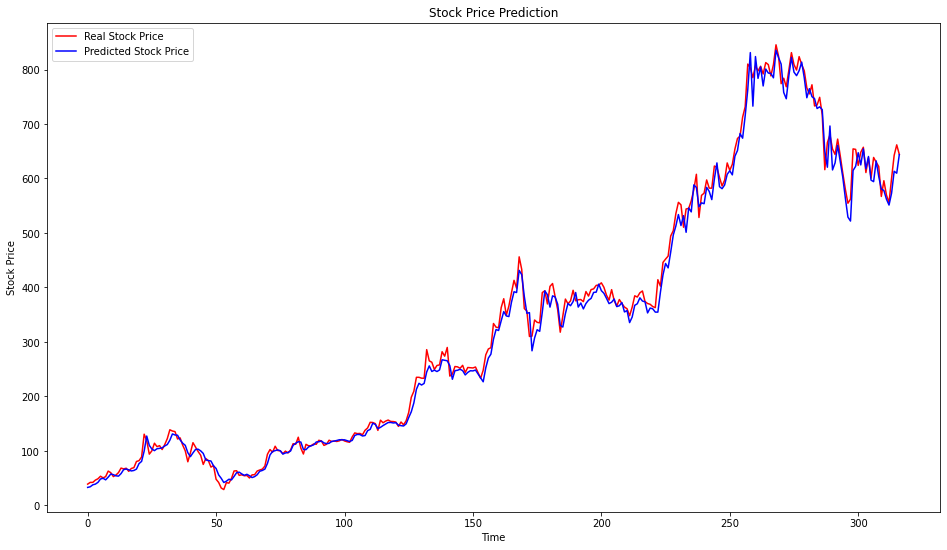

In [ ]:
# Visualising the results
plt.figure(figsize=(16,9))
plt.plot(y_test, color = 'red', label = 'Real Stock Price')
plt.plot(y_pred, color = 'blue', label = 'Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [ ]:
!kill 2685
%load_ext tensorboard
%tensorboard --logdir my_dir

/bin/bash: line 0: kill: (2685) - No such process


Reusing TensorBoard on port 6006 (pid 1049), started 1:23:47 ago. (Use '!kill 1049' to kill it.)

<IPython.core.display.Javascript object>